In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import sklearn.calibration
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

# prepare data

In [2]:
# currently trained only on 'clath_aux+gak_a7d2_new'
# dsets = ['clath_aux+gak_new']
dsets = ['clath_aux_dynamin']
splits = ['test']
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open(config.FINAL_MODEL, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
df = dfs[list(dfs.keys())[0]]
X = df[feat_names[:p]]
y = df['y_consec_thresh']


# add preds
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
# df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

# sort things
print(f'acc {np.mean((preds > 0) == y):0.3f} vs baseline {1-np.mean(y):0.2f}', )

100%|██████████| 1/1 [00:11<00:00, 11.08s/it]


type <class 'dict'>
acc 0.841 vs baseline 0.66


# calibration plot

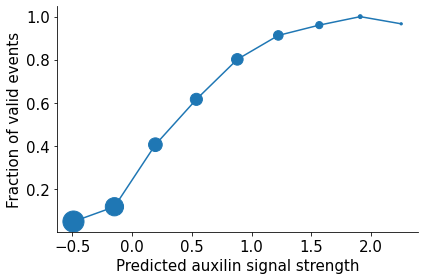

In [4]:
nbins = 10
delta = (preds.max() - preds.min()) / nbins
bins = np.linspace(preds.min(), preds.max(), nbins)
accs = (preds > 0)==y
prob_trues = []
num_pts = []
for i in range(nbins - 1):
    idxs = (preds > bins[i]) & (preds <= bins[i+1])
    num_pts.append(idxs.sum())
    prob_trues.append(y[idxs].mean())
plt.scatter(bins[:-1] + delta, prob_trues, s=np.array(num_pts)/6)    
plt.plot(bins[:-1] + delta, prob_trues, color=viz.cb)
plt.xlabel('Predicted auxilin signal strength')
plt.ylabel('Fraction of valid events')
plt.tight_layout()
viz.savefig('calibration')

# scatter plots

In [18]:
ys = df['Y_sig_mean_normalized'].values

In [17]:
from scipy.stats import percentileofscore

In [20]:
preds_perc = [percentileofscore(ys, score=p) for p in preds]

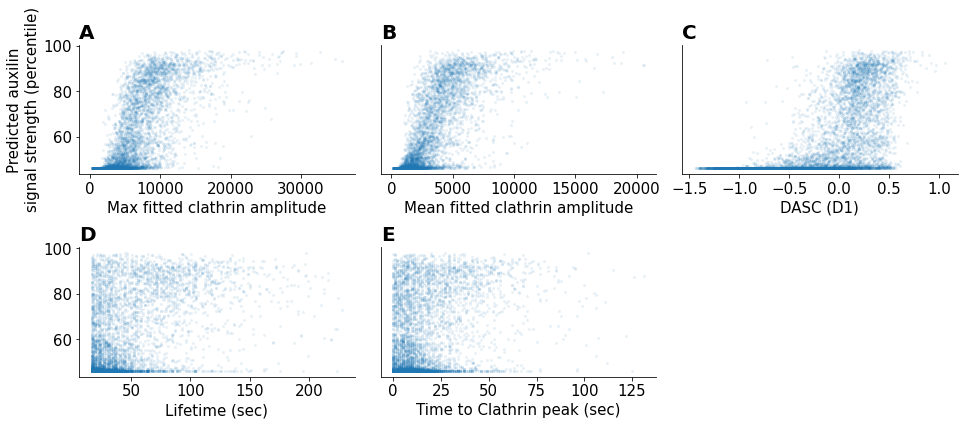

In [24]:
R, C = 2, 3
vabs = max(abs(df['preds'])) // 2
norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
kwargs = dict(
    cmap=viz.cmap,
    norm=norm,
    alpha=0.5,
    s=14, edgecolors=None
)
plt.figure(figsize=(C * 4.5, R * 3))

plt.subplot(R, C, 1)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['X_max'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Max fitted clathrin amplitude')
plt.ylabel('Predicted auxilin\nsignal strength (percentile)')
plt.title('A', loc='left', fontweight='bold')

plt.subplot(R, C, 2)
# plt.axhline(0, color='gray', alpha=0.5)
plt.yticks([])
plt.plot(df['X_mean'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Mean fitted clathrin amplitude')
plt.title('B', loc='left', fontweight='bold')

plt.subplot(R, C, 3)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['X_d1'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('DASC (D1)')
plt.yticks([])
plt.title('C', loc='left', fontweight='bold')

plt.subplot(R, C, 4)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['lifetime'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Lifetime (sec)')
# plt.ylabel('Predicted auxilin\nsignal strength')
# plt.yticks([])
plt.title('D', loc='left', fontweight='bold')

plt.subplot(R, C, 5)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['X_peak_idx'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Time to Clathrin peak (sec)')
plt.yticks([])
plt.title('E', loc='left', fontweight='bold')

'''
plt.subplot(R, C, 6)
plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['lifetime'] - df['X_peak_idx'], df['preds'], '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Time after Clathrin peak')
plt.yticks([])
plt.title('F', loc='left', fontweight='bold')
'''

viz.savefig('top_feats_scatter')

# colored scatter plot (deprecated)

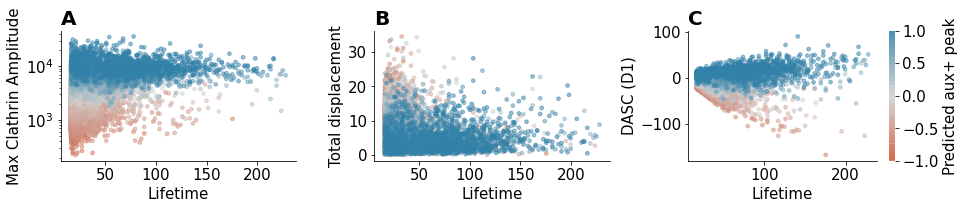

In [10]:
R, C = 1, 3
vabs = max(abs(df['preds'])) // 2
norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
kwargs = dict(
    cmap=viz.cmap,
    norm=norm,
    alpha=0.5,
    s=14, edgecolors=None
)
plt.figure(figsize=(C * 4.5, R * 3))
plt.subplot(R, C, 1)
plt.scatter(df['lifetime'], df['X_max'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Max Clathrin Amplitude')
plt.yscale('log')
plt.title('A', loc='left', fontweight='bold')

plt.subplot(R, C, 2)
plt.scatter(df['lifetime'], df['mean_total_displacement'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Total displacement')
plt.title('B', loc='left', fontweight='bold')

plt.subplot(R, C, 3)
plt.scatter(df['lifetime'], df['X_d1'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('DASC (D1)')
plt.title('C', loc='left', fontweight='bold')
cb = plt.colorbar(label='Predicted aux+ peak')
cb.outline.set_visible(False)
viz.savefig('top_feats_scatter')

# viz errs

**analysis version (not figure)**

In [ ]:
# for analysis (not figure)
y = df['y_consec_thresh'].astype(bool)
p = df['preds'].values > 0
ylims = {'fn': (-500, 3000), 
         'tn': (-500, 3000), 
         'fp': (-500, 18000),
         'tp': (-500, 30000)}
lifetimes = {'fn': 20, 
             'tn': 20, 
             'fp': 60,
             'tp': 100}

tp = y & p
tn = ~y & ~p
fp = ~y & p
fn = y & ~p
print('fracs', 'fp', fp.sum() / y.size, 'fn', fn.sum() / y.size)
err_pids = {}
#for idxs, name in zip([fn, fp], ['fn', 'fp']):   
for idxs, name in zip([tp], ['tp']): 
    print(name)
    d = df[idxs]
    d = d.sort_values(by='preds', ascending=False)
    errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                                d['preds'] > 0, d['preds'],
                                num_to_plot=36, # 20 makes best plots
                                show_track_pid=True,
                                show_track_num=False,
                                sort_by_residuals=False,
                                lifetime_max=lifetimes[name],
                                plot_z=True,
                                ylim=ylims[name],
                                text_labels=idxs is fn)
    err_pids[name] = errs['pid'].values[:36]

**figure version**

In [ ]:
# for figure
y = df['y_consec_thresh'].astype(bool)
p = df['preds'].values > 0

tp = y & p
tn = ~y & ~p
fp = ~y & p
fn = y & ~p
for setup in ['small', 'big']:
    if setup == 'small':
        R = 2
        C = 2
        text_label_size = 15
        width_mult = 4
    elif setup == 'big':
        R = 6
        C = 6
        text_label_size = 25
        width_mult = 3
    print('fracs', 'fp', fp.sum() / y.size, 'fn', fn.sum() / y.size)
    for idxs, name in zip([fn, fp], ['fn', 'fp']):    
        print(name)
        d = df[idxs]
        errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                                    d['preds'] > 0, d['preds'],
                                    num_to_plot=R*C, # 20 makes best plots
                                    show_track_pid=False,
                                    show_track_num=False,
                                    plot_z=True,
                                    width_mult=width_mult,
                                    plot_axhline=False,
                                    lifetime_max=40,
                                    ylim=(-500, 30000),
                                    yticks=[1e3, 1e4],
                                    yticklabels=[0, "$10^4$"],
                                    text_labels=idxs is fn,
                                    text_label_size=text_label_size)

        # print(errs['pid'].values[:36])
        plt.subplot(R, C, 1 + C * R//2)
        plt.ylabel('Fitted Amplitude')
        plt.subplot(R, C, C * (R - 1) + C//2)
        plt.xlabel('Time')
    #     plt.tight_layout()
    #     fig.supxlabel('Event duration')

        viz.savefig(f'{name}_{setup}')
        plt.show()

In [7]:
df.keys()

Index(['lifetime', 'cell_num', 'catIdx', 't', 'mean_total_displacement',
       'mean_square_displacement', 'x_pos_seq', 'y_pos_seq', 'x_pos', 'y_pos',
       'X_pvals', 'X_extended', 'X', 'X_starts', 'X_ends', 'Y_pvals', 'Y',
       'Y_starts', 'Y_ends', 'Z_pvals', 'Z', 'Z_starts', 'Z_ends',
       'lifetime_extended', 'pid', 'valid', 'X_max', 'X_max_extended', 'X_min',
       'X_mean', 'X_std', 'Y_max', 'Y_mean', 'Y_std', 'X_peak_idx',
       'Y_peak_idx', 'X_peak_time_frac', 'X_peak_last_15', 'X_peak_last_5',
       'rise', 'fall', 'rise_extended', 'fall_extended', 'fall_late_extended',
       'rise_slope', 'fall_slope', 'rise_local_3', 'fall_local_3',
       'rise_local_11', 'fall_local_11', 'max_diff', 'min_diff', 'y_score',
       'y_thresh', 'y', 'y_num_sig', 'y_single_sig', 'y_double_sig',
       'y_conservative_thresh', 'y_consec_sig', 'y_sig_min_diff',
       'y_consec_thresh', 'sig_idxs', 'hotspots', 'Y_peak_time_frac',
       'y_z_score', 'X_max_around_Y_peak', 'X_max_after

## kymographs

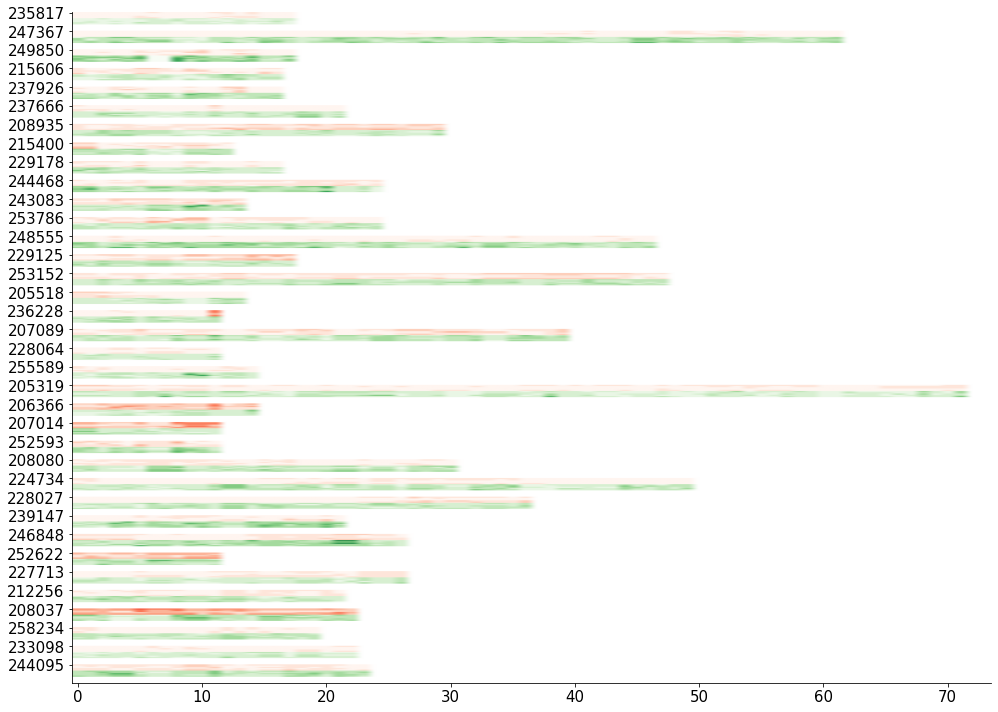

In [39]:
# fps = errs['pid'].values[:36]
tps = df[tp]['pid'].values[:36]
cla_traces, aux_traces, kg = viz.plot_kymographs(df, tps)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(kg, aspect=.1)
plt.yticks(np.arange(0, 3 * 5 * len(tps), 3 * 5), tps)
plt.show()

# cohort plots

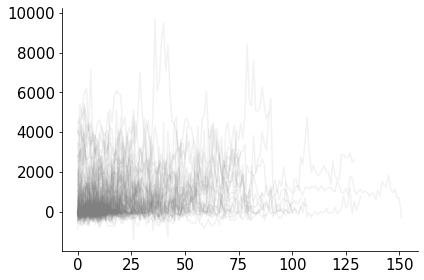

In [24]:
from viz import cr, cp, cg
dd = df.sort_values(by='pid')
for i in range(200):
    plt.plot(dd.iloc[i]['Z'], color='gray', alpha=0.1)
    

# cumulative errs

In [6]:
# currently trained only on 'clath_aux+gak_a7d2_new'
# dsets = ['clath_aux+gak_new']
dsets = ['clath_aux_dynamin']
splits = ['test']
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False, filter_short=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open(config.FINAL_MODEL, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
dd = dfs[list(dfs.keys())[0]]
dd = dd[dd.short]
dfull = pd.concat((df, dd), axis=0)
dfull['preds_proba'] = dnn.predict(dfull[feat_names[:1]])
dfull['preds'] = (dfull['preds_proba'].values > 0).astype(int)

100%|██████████| 1/1 [00:47<00:00, 47.11s/it]


type <class 'dict'>


accsf 35754.0
(40304,) (31853,) (8451,) (40304,)
[1. 1. 1. ... 0. 0. 1.]


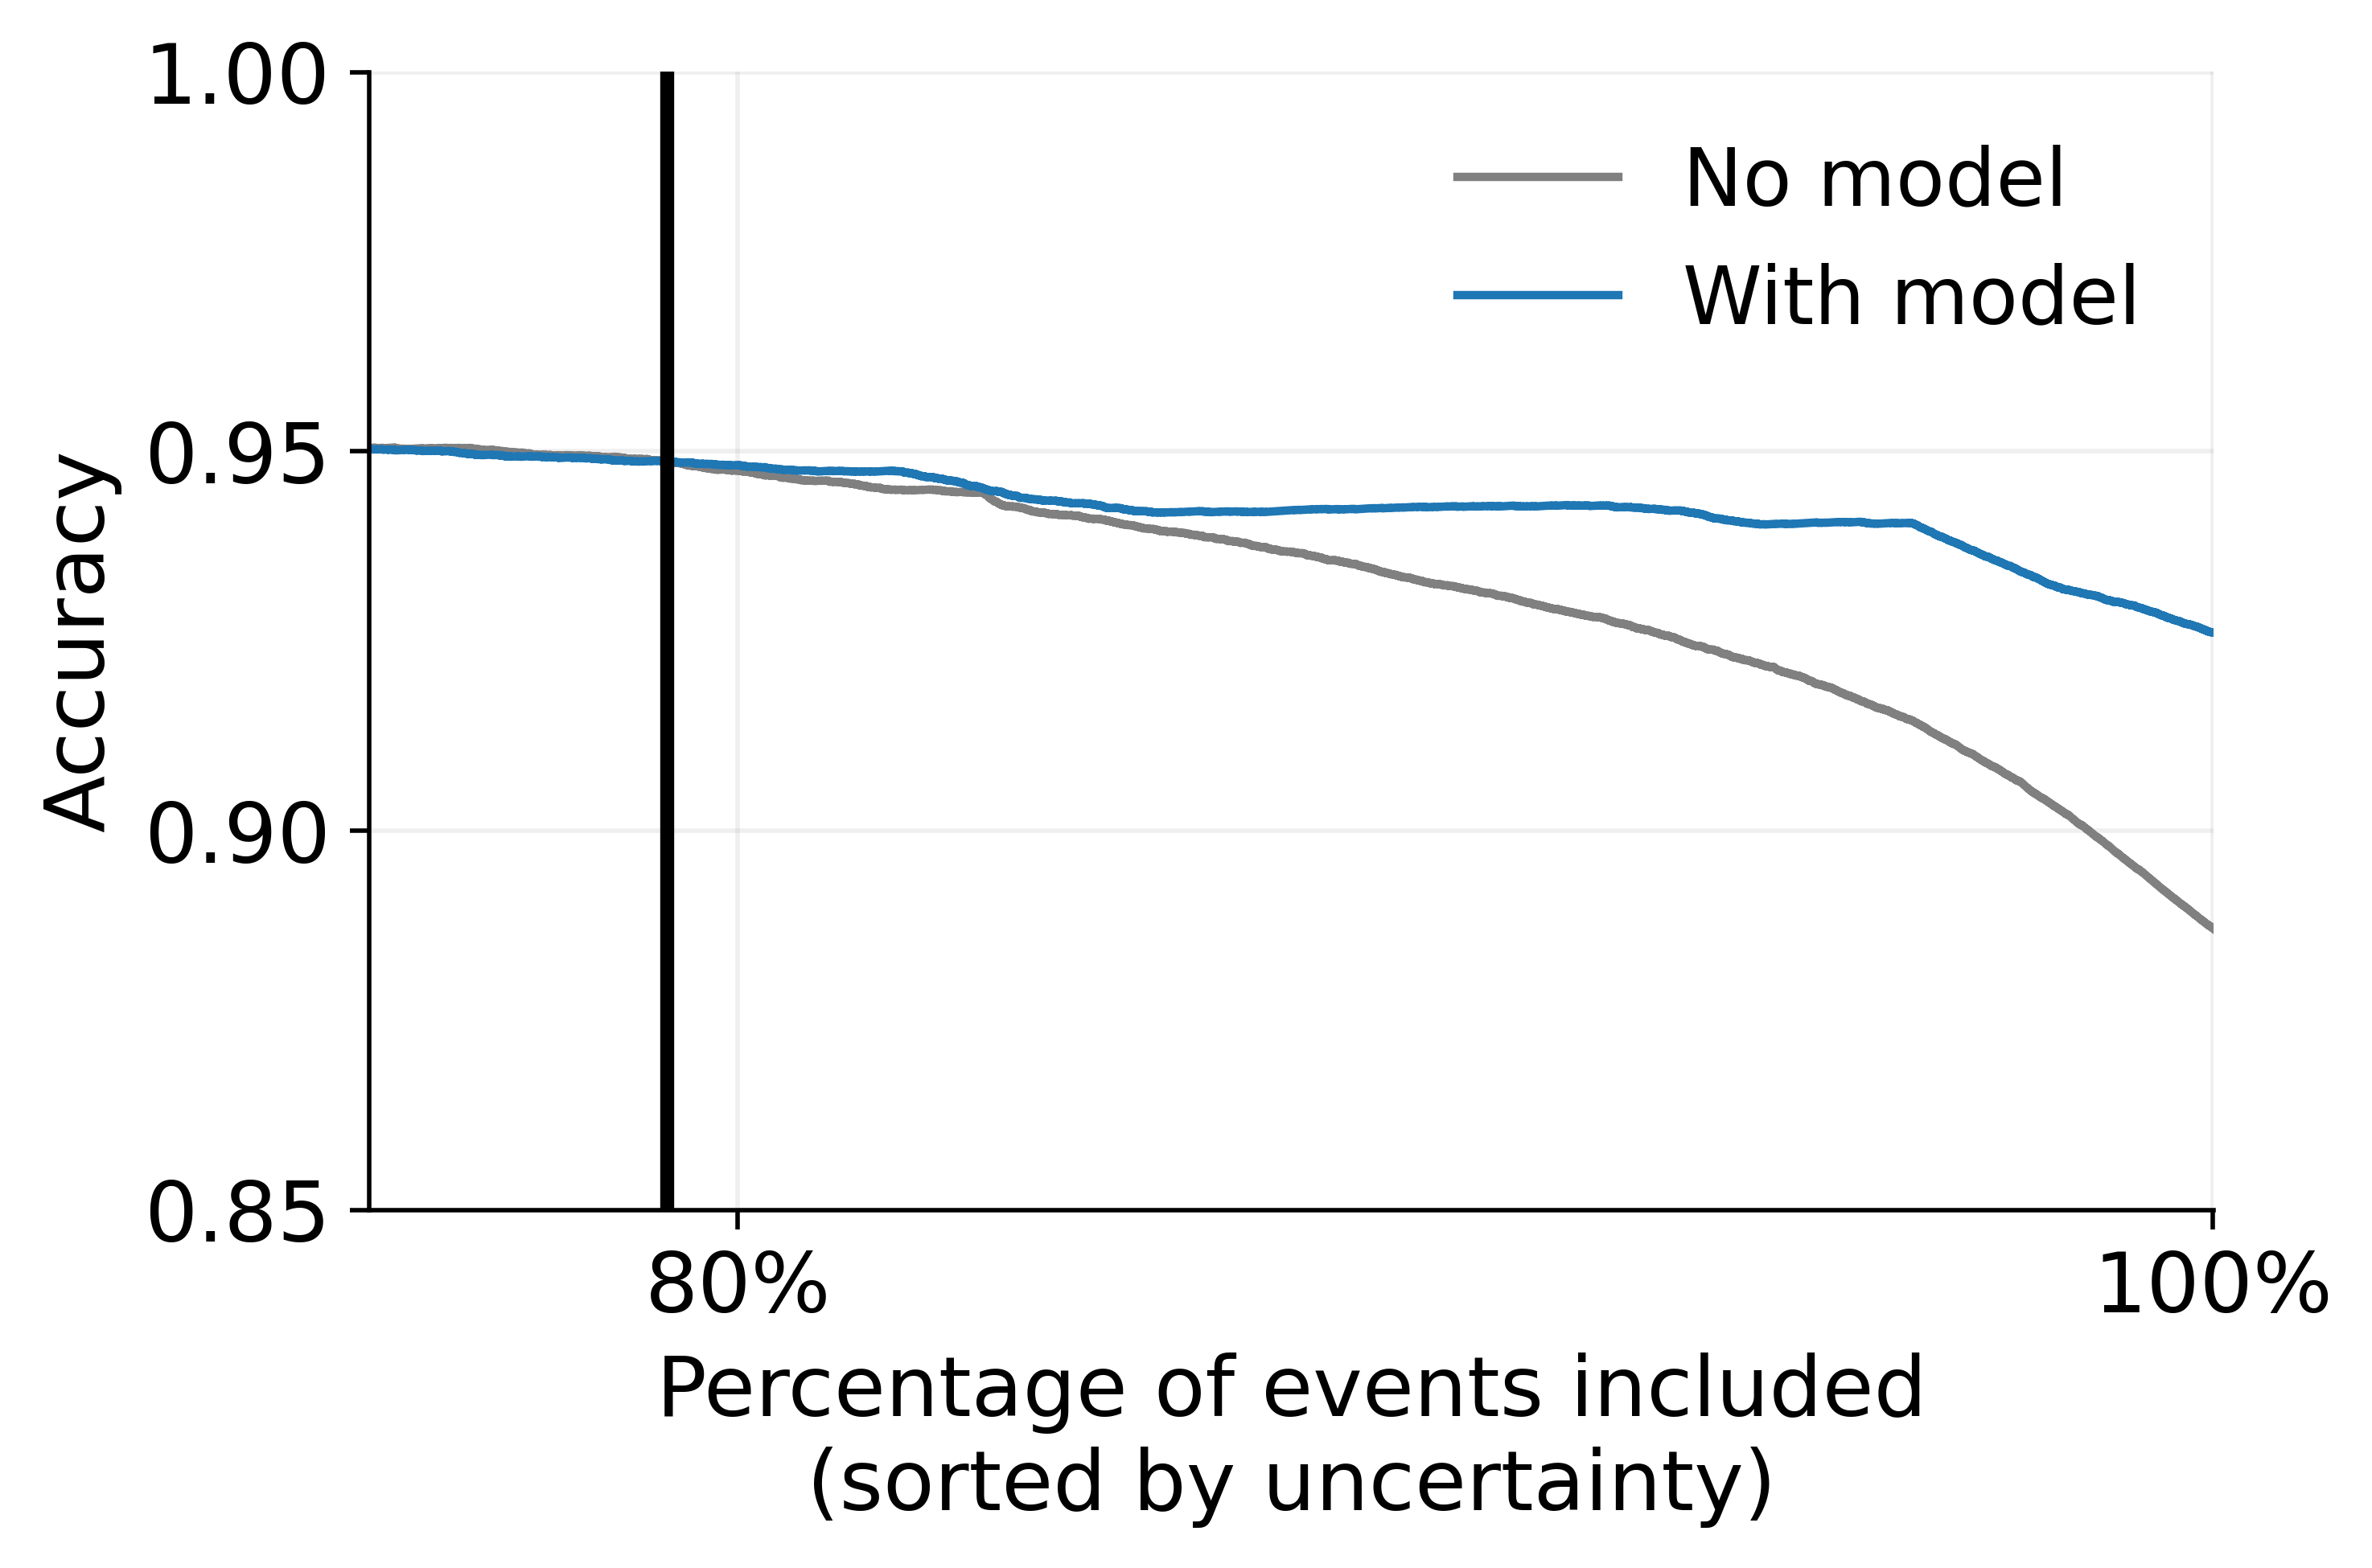

In [8]:
viz.cumulative_acc_plot_all(df=dfull,
                            pred_proba_key='preds_proba',
                            pred_key='preds',
                            outcome_def='y_consec_thresh', show=False)
plt.xlabel('Percentage of events included\n(sorted by uncertainty)')
plt.xlim((dfull.shape[0]*3/4, dfull.shape[0]))
plt.ylim((0.85, 1.0))
viz.savefig('cum_acc')

# correcting labels

In [ ]:
for idxs, name in zip([fp, fn], ['fp', 'fn']):    
    d = df[idxs]
    errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                                d['preds'] > 0, d['preds'],
                                plot_z=True,
#                                 lifetime_max=100,
                                sort_by_residuals=False,
                                show_track_num=True,
                                num_to_plot=idxs.sum(),
                               )
    plt.savefig(name + '.pdf')
#     viz.savefig(name)

In [57]:
pos_fp = np.array([
    2, 5, 6, 7, 8, 9, 12, 13, 14, 16, 18, 19, 21, 32, 36, 37, 38, 39, 43, 44, 52, 56, 59, 71, 72, 76, 80, 81, 97, 98,
    108, 109, 111, 120, 122, 126, 129, 138, 165, 166, 168, 183, 185, 195, 202, 216, 224, 225, 232, 242, 243, 244, 246,
    247, 261, 268, 279, 288, 294, 308, 324, 326, 327, 340, 342, 345, 346, 365, 378, 380, 396, 401, 425, 440, 447, 485,
    495, 512, 541, 544, 576, 612, 620, 625, 632, 649, 654, 663, 665, 666, 672, 688, 699, 706, 707, 717, 734, 745, 771,
    816, 837, 846, 851, 857, 874, 876, 887, 893, 896, 903, 910, 935, 951, 964, 975, 982, 990, 998, 1000, 1006, 1011,
    1015, 1019, 1021, 1023, 1030, 1031, 1036, 1039, 1045, 1050, 1058, 1061, 1063, 1064, 1070, 1071, 1082, 1086, 1093,
    1095, 1099, 1110, 1113, 1118, 1122, 1126, 1127, 1132, 1143, 1150, 1152, 1155,
])

hotspots_fp = np.array([
    25, 58, 69, 70, 73, 91, 105, 106, 107, 141, 142, 145, 151, 161, 162, 164, 172, 218, 234, 241, 254, 277, 297, 317,
    320, 338, 341, 362, 363, 364, 373, 390, 411, 415, 473, 474, 523, 524, 539, 556, 571, 572, 603, 604, 606, 608, 611,
    613, 621, 624, 638, 639, 640, 648, 676, 679, 686, 692, 702, 703, 715, 743, 744, 762, 774, 775, 777, 781, 786, 790,
    795, 801, 805, 811, 820, 822, 828, 832, 839, 841, 853, 854, 860, 861, 866, 870, 881, 886, 894, 897, 906, 916, 922,
    936, 940, 941, 949, 958, 965, 972, 974, 977, 980, 984, 986, 987, 992, 994, 996, 1001, 1005, 1010, 1013, 1014, 1017,
    1026, 1035, 1037, 1038, 1052, 1053, 1072, 1075, 1078, 1081, 1085, 1087, 1088, 1089, 1092, 1094, 1096, 1097, 1100,
    1101, 1102, 1104, 1107, 1111, 1112, 1114, 1115, 1119, 1120, 1121, 1123, 1124, 1129, 1134, 1145, 1146, 1148, 1154,
])

neg_fn = np.array([
    1, 3, 5, 11, 12, 24, 29, 33, 37, 38, 39, 45, 48, 49, 59, 61, 62, 63, 64, 65, 68, 69, 72, 73, 79, 80, 91, 92, 93, 94,
    99, 101, 104, 105, 106, 107, 108, 113, 123, 124, 127, 131, 132, 136, 138, 140, 141, 147, 149, 153, 154, 156, 160,
    165, 166, 167, 170, 174, 176, 183, 185, 188, 189, 191, 192, 196, 200, 207, 208, 211, 213, 214, 215, 219, 227, 228,
    230, 321, 233, 254, 257, 259, 260, 274, 281, 285, 287, 288, 296, 297, 309, 332, 363, 378, 381, 382, 383, 384, 385,
    393, 394, 402, 405, 413, 427, 478, 482, 483, 509, 512, 513, 514, 520, 524, 527, 544, 548, 549, 552, 556, 557, 559,
    579, 599, 608, 617,
])

hotspots_fn = np.array([
    148, 240, 244, 250, 251, 252, 261, 283, 293, 317, 318, 366, 410, 412, 428, 432, 459, 460, 462, 463, 470, 503, 518,
    519, 565, 568, 589, 590, 600, 605, 614, 619,
])

In [ ]:
d_fp = df[fn]
d = d_fp.iloc[hotspots_fn]
errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                            d['preds'] > 0, d['preds'],
                            plot_z=True,
                            sort_by_residuals=False,
                            num_to_plot=25
                           )

In [62]:
d.pid.values

array([242828, 254428, 257377, 207581, 235660, 205824, 225114, 213307,
       209487, 206981, 239467, 252051, 205115, 206939, 226274, 242758,
       228777, 256040, 255719, 235465, 209012, 222720, 256464, 223698,
       254836, 223231, 254747, 255906, 253835, 254133, 204951, 254969])